# AutoExpo 2016 Analysis


## First step :   Collecting tweets with help of Twitter Streaming API

In [30]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import json
import string
import re
import operator 
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


### Total Number of tweets and sample tweets

In [3]:
tweets = []
tweets_file = open('tweets.json', 'r',encoding='utf-8')
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets.append(tweet)
    except:
        continue
        
print('Sample Tweet in JSON Format : \n')
print(json.dumps(tweets[1:2],indent=4))

Sample Tweet in JSON Format : 

[
    {
        "id": 695592766412341248,
        "possibly_sensitive": false,
        "lang": "en",
        "entities": {
            "urls": [
                {
                    "display_url": "ln.is/www.youtube.co\u2026",
                    "expanded_url": "http://ln.is/www.youtube.com/bqd3I",
                    "url": "https://t.co/q2m8ZPbkn7",
                    "indices": [
                        112,
                        135
                    ]
                }
            ],
            "symbols": [],
            "hashtags": [
                {
                    "text": "DatsunPavilion",
                    "indices": [
                        84,
                        99
                    ]
                },
                {
                    "text": "AETMS2016",
                    "indices": [
                        100,
                        110
                    ]
                }
            ],
            "user

In [4]:
print('Total Numbe of tweets of tweets:', len(tweets))
print('\n')
print('Example tweets : \n')
for tweet in tweets[:3]:
    print(tweet['text'])
    print('---------------------------------------------------------------------------------')

Total Numbe of tweets of tweets: 24087


Example tweets : 

RT @PressPlayTVapp: Get all action from @AutoExpo2016  on #PressPlay! Download the App Now: https://t.co/WIEt5hbRZ5 #automobile #AETMS16 ht…
---------------------------------------------------------------------------------
Now GO-cross Concept has added a sense of fun &amp; adventure to the line-up at the #DatsunPavilion #AETMS2016  https://t.co/q2m8ZPbkn7
---------------------------------------------------------------------------------
RT @AutoExpo2016: It's raining celebrities at #AETMS16! #Spotted the dashing @AnilKapoor at the @Maruti_Corp pavilion @NexaExperience https…
---------------------------------------------------------------------------------


# Text Preprocessing

### 1. In this part collected tweets are preprocessed i.e Tokenizing the text.

In [5]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'[^\x00-\x7F]+',#unicode
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
 
tweet = "RT @PressPlayTVapp: Get all action from @AutoExpo2016  on #PressPlay! Download the App Now: https://t.co/WIEt5hbRZ5 #automobile #AETMS16 ht…"

print('Tweet after preprocessing : \n')
print(preprocess(tweet))

Tweet after preprocessing : 

['RT', '@PressPlayTVapp', ':', 'Get', 'all', 'action', 'from', '@AutoExpo2016', 'on', '#PressPlay', '!', 'Download', 'the', 'App', 'Now', ':', 'https://t.co/WIEt5hbRZ5', '#automobile', '#AETMS16', 'ht', '…']


### 2. Removing Stopwords i.e unnecessary words will be removed

In [6]:
import nltk
from nltk.corpus import stopwords
import string
punctuation = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', 
               '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

hindiwords = nltk.corpus.indian.words('hindi.pos')

stop = stopwords.words('english') + punctuation + ['RT', 'via','#AETMS2016','#AutoExpo2016','Auto','Expo','2016','amp','The','\xa0','…','https']


In [7]:
tweet = "RT @PressPlayTVapp: Get all action from @AutoExpo2016  on #PressPlay! Download the App Now: https://t.co/WIEt5hbRZ5 #automobile #AETMS16 ht…"
after_stop = [term for term in preprocess(tweet) if term not in stop]
print('Tweets before preprocessing : \n')
print(tweet)
print('\nTweets after preprocessing : \n')
print(' '.join(after_stop))

Tweets before preprocessing : 

RT @PressPlayTVapp: Get all action from @AutoExpo2016  on #PressPlay! Download the App Now: https://t.co/WIEt5hbRZ5 #automobile #AETMS16 ht…

Tweets after preprocessing : 

@PressPlayTVapp Get action @AutoExpo2016 #PressPlay Download App Now https://t.co/WIEt5hbRZ5 #automobile #AETMS16 ht


## Term Frequency

### In this part we output the Top Hastags,Mentions,Terms used and Language

In [8]:
fname = 'tweets.json'
with open(fname, 'r') as f:
    hashtag = Counter()
    mention = Counter()
    termOnly = Counter()
    count_all = Counter()
    
    lang = []
    
    for line in f:
        try:
            tweet = json.loads(line)
            
            terms_stop = [term for term in preprocess(tweet['text']) if term not in stop]
            
            terms_hash = [term for term in preprocess(tweet['text']) if term.startswith('#') and term != '#']
            
            terms_only = [term for term in preprocess(tweet['text']) if term not in stop and not term.startswith(('#', '@'))] 
            
            terms_mention = [term for term in preprocess(tweet['text']) if term.startswith('@') and term != '@']
            
            if tweet['lang'] != 'und':
                lang.append(tweet['lang'])
            
            lang_count = Counter(lang)

            count_all.update(terms_stop)
            
            hashtag.update(terms_hash)
            
            mention.update(terms_mention)
            
            termOnly.update(terms_only)
        except ValueError:
            continue


In [16]:
hashtag_df = DataFrame(hashtag.most_common())
mention_df = DataFrame(mention.most_common())
termOnly_df = DataFrame(termOnly.most_common())
lang_df = DataFrame(lang_count.most_common())
hashtag_df.columns = ['Hashtags','Hashtag_count']
mention_df.columns = ['Mentions','Mention_count']
termOnly_df.columns = ['TermsOnly','Term_count']
lang_df.columns = ['Language','Language_count']

In [17]:
hashtag_df.head()

,Hashtags,Hashtag_count
0,#AutoExpo2016,7190
1,#AETMS16,1764
2,#NissanPavilion,1714
3,#AETMS2016,1047
4,#ToyotaAtAutoExpo,889


In [18]:
mention_df.head()

,Mentions,Mention_count
0,@AutoExpo2016,5164
1,@Nissan_India,1364
2,@FordIndia,1007
3,@honda2wheelerin,1001
4,@Toyota_India,880


In [19]:
termOnly_df.head()

,TermsOnly,Term_count
0,India,1727
1,new,1087
2,BMW,1056
3,2,1008
4,Hall,785


In [20]:
lang_map  ={'ar':'Arabic','bg':'Bulgarian','bn':'Bengali','cs':'czech','cy':'Welsh','da':'Danish','de':'German','el':'Greek',
            'en':'English','es':'Spanish','et':'Estonian','fi':'Finish','fr':'French','gu':'Gujrati','hi':'Hindi','ht':'Haitian Creole',
           'in':'Indonesian','is':'icelandic','it':'Italian','ja':'Japenese','kn':'Kannada','lt': 'Lithuanian','lv': 'Latvian',
            'ml': 'Malayalam','mr': 'Marathi','ne': 'Nepali','nl': 'Dutch','no': 'Norwegian','pa': 'Punjabi','pl': 'Polish',
            'pt': 'Portuguese','ro': 'Romanian','ru': 'Russian','si': 'Sinhalese','sl': 'Slovenian','sv': 'Swedish','ta': 'Tamil',
            'te': 'Telugu','tl': 'Tagalog','tr': 'Turkish'}
lang_df['Language'] = lang_df['Language'].map(lang_map)
lang_df

,Language,Language_count
0,English,20937
1,Indonesian,532
2,Hindi,469
3,Tagalog,354
4,Spanish,235
5,Italian,148
6,German,65
7,French,58
8,Portuguese,50
9,Estonian,34


In [21]:
freq_df = pd.concat([hashtag_df,mention_df,termOnly_df,lang_df],axis=1)
freq_df.head()

,Hashtags,Hashtag_count,Mentions,Mention_count,TermsOnly,Term_count,Language,Language_count
0,#AutoExpo2016,7190,@AutoExpo2016,5164,India,1727,English,20937
1,#AETMS16,1764,@Nissan_India,1364,new,1087,Indonesian,532
2,#NissanPavilion,1714,@FordIndia,1007,BMW,1056,Hindi,469
3,#AETMS2016,1047,@honda2wheelerin,1001,2,1008,Tagalog,354
4,#ToyotaAtAutoExpo,889,@Toyota_India,880,Hall,785,Spanish,235


## Top 10 Popular Langauges

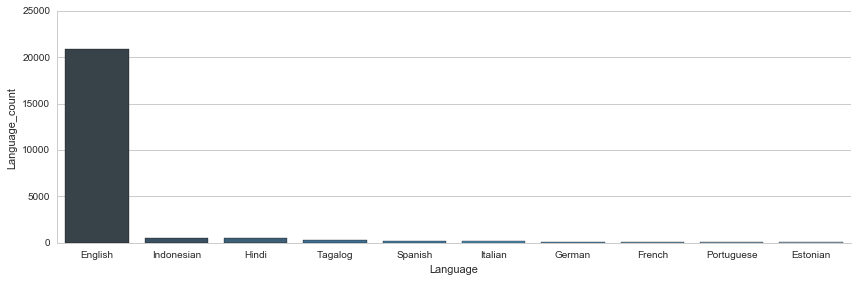

In [25]:
sns.factorplot(x='Language',y='Language_count',data=freq_df[:10],kind='bar',legend=True,orient="v",aspect=3,palette='Blues_d')

## Top 10 Popular hashtags

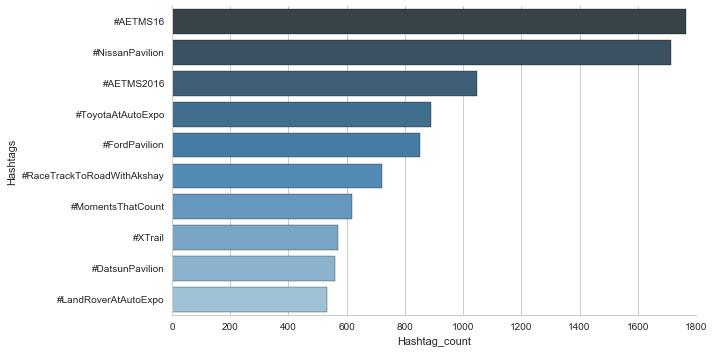

In [26]:
sns.factorplot(x='Hashtag_count',y='Hashtags',data=freq_df[1:11],kind='bar',legend=True,orient="h",size=5,aspect=2,palette='Blues_d')

## Top 10 Popular Mentions

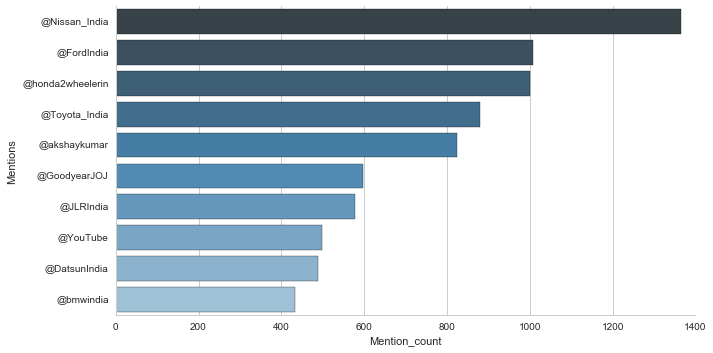

In [27]:
sns.factorplot(x='Mention_count',y='Mentions',data=freq_df[1:11],kind='bar',legend=True,orient="h",size=5,aspect=2,palette='Blues_d')

## Top 10 Popular Terms other than hastags and mentions

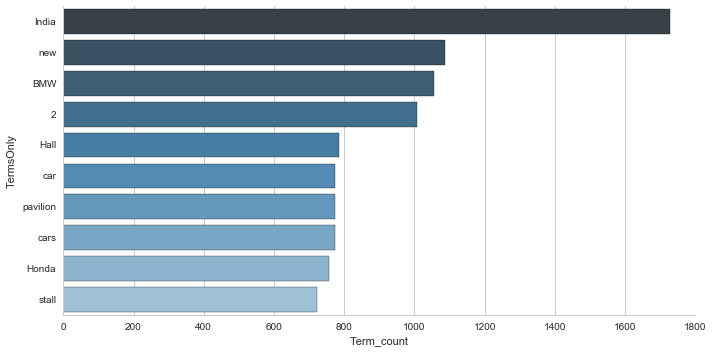

In [29]:
sns.factorplot(x='Term_count',y='TermsOnly',data=freq_df[:10],kind='bar',legend=True,orient="h",size=5,aspect=2,palette='Blues_d')

In [37]:
autoExpo_df = DataFrame(tweets)
autoExpo_df.head()

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,filter_level,geo,id,...,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user
0,None,None,Fri Feb 05 13:00:05 +0000 2016,{'urls': [{'display_url': 'hyperurl.co/presspl...,{'media': [{'expanded_url': 'http://twitter.co...,0,False,low,None,695592733998710785,...,NaN,NaN,0,False,"{'id': 695231675727360007, 'possibly_sensitive...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @PressPlayTVapp: Get all action from @AutoE...,1454677205930,False,"{'default_profile_image': False, 'id': 3800552..."
1,None,None,Fri Feb 05 13:00:13 +0000 2016,{'urls': [{'display_url': 'ln.is/www.youtube.c...,NaN,0,False,low,None,695592766412341248,...,NaN,NaN,0,False,NaN,"<a href=""http://linkis.com"" rel=""nofollow"">Lin...",Now GO-cross Concept has added a sense of fun ...,1454677213658,False,"{'default_profile_image': False, 'id': 3831798..."
2,None,None,Fri Feb 05 13:00:17 +0000 2016,"{'urls': [], 'media': [{'expanded_url': 'http:...",{'media': [{'expanded_url': 'http://twitter.co...,0,False,low,None,695592780588929024,...,NaN,NaN,0,False,"{'id': 695572901282476032, 'possibly_sensitive...","<a href=""http://twitter.com/download/iphone"" r...",RT @AutoExpo2016: It's raining celebrities at ...,1454677217038,False,"{'default_profile_image': False, 'id': 3108283..."
3,None,None,Fri Feb 05 13:00:18 +0000 2016,{'urls': [{'display_url': 'vine.co/v/iJ0QjLV6a...,NaN,0,False,low,None,695592786377252864,...,NaN,NaN,0,False,NaN,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","The Honda BR-V at the #AutoExpo2016 , how does...",1454677218418,False,"{'default_profile_image': False, 'id': 2982269..."
4,None,None,Fri Feb 05 13:00:20 +0000 2016,"{'urls': [{'display_url': 't.in.com/aZg7', 'ex...",{'media': [{'expanded_url': 'http://twitter.co...,0,False,low,None,695592795348664320,...,NaN,NaN,0,False,"{'id': 695571157970350080, 'possibly_sensitive...","<a href=""http://twitter.com/download/android"" ...",RT @moneycontrolcom: BMW launches X5 xDrive30d...,1454677220557,False,"{'default_profile_image': False, 'id': 1247596..."


In [50]:
autoExpo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24087 entries, 0 to 24086
Data columns (total 31 columns):
contributors                 0 non-null object
coordinates                  129 non-null object
created_at                   24087 non-null object
entities                     24087 non-null object
extended_entities            10366 non-null object
favorite_count               24087 non-null int64
favorited                    24087 non-null bool
filter_level                 24087 non-null object
geo                          129 non-null object
id                           24087 non-null int64
id_str                       24087 non-null object
in_reply_to_screen_name      2358 non-null object
in_reply_to_status_id        1475 non-null float64
in_reply_to_status_id_str    1475 non-null object
in_reply_to_user_id          2358 non-null float64
in_reply_to_user_id_str      2358 non-null object
is_quote_status              24087 non-null bool
lang                         24087 non-nu